In [99]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
from statsmodels.tsa.stattools import adfuller
from scipy.optimize import curve_fit
from ydata_profiling import ProfileReport
import scipy.optimize
import scipy.stats as stats

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.arima.model import ARIMA

from statsmodels.tsa.stattools import pacf, acf




# Dane 

In [100]:
df_count = pd.read_csv('date_counts.csv')
print(df_count.columns)
count = df_count["Count"]
dates = df_count['Date']

n = len(count)
dates = pd.to_datetime(df_count['Date'])
n = len(count)
date0 = dates.iloc[0]
date_last = dates.iloc[-1]
timedelta = date_last - date0

print(n)
print("First day:", dates[0], "\nLast day:", dates[n-1], "\n Timedelta (this should be lenght of our data):", timedelta)
print("Maximum number of crimes:", max(count), "\nMinimum number of crimes:", min(count))

Index(['Date', 'Count'], dtype='object')
4017
First day: 2009-01-01 00:00:00 
Last day: 2019-12-31 00:00:00 
 Timedelta (this should be lenght of our data): 4016 days 00:00:00
Maximum number of crimes: 170 
Minimum number of crimes: 21


In [101]:
# Filtrujemy daty od 1 stycznia 2014
filtered_data = df_count[dates >= '2016-01-01']

# Wyodrębniamy tylko kolumnę 'Count' z przefiltrowanych danych
count_2014 = filtered_data["Count"]
count_2014.to_csv('count_2014.csv', index=False)

df_count_2014 = pd.read_csv('count_2014.csv')

In [102]:
profile = ProfileReport(df_count, title = "Number of crimes")
profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

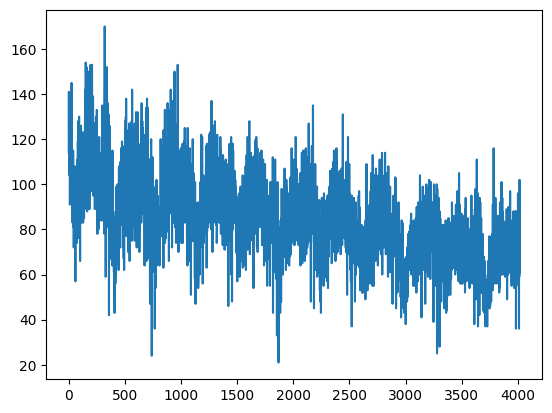

In [103]:
plt.plot(count)


Obcięcie danych

In [104]:
n_cut = int(0.99*len(count))
count_99 = count[:n]

# Test ADF - wejsciowe dane

In [105]:
result = adfuller(count_99)
print("Hipoteza zerowa: dane są niestacjonarne")
print("Hipoteza alternatywna: dane są stacjonwarne")


print("ADF Statistic:", result[0])
print("p-value:", result[1])
print("Liczba opóźnień:", result[2])
print("Liczba obserwacji użytych do testu:", result[3])
print("Wartości krytyczne:")
for key, value in result[4].items():
    print(f"   {key}: {value:.3f}")

if result[1] < 0.05:
    print("Odrzucamy hipotezę zerową (dane są stacjonarne).")
else:
    print("Nie można odrzucić hipotezy zerowej (dane są niestacjonarne).")

Hipoteza zerowa: dane są niestacjonarne
Hipoteza alternatywna: dane są stacjonwarne
ADF Statistic: -3.6113919773339607
p-value: 0.0055469354372394445
Liczba opóźnień: 29
Liczba obserwacji użytych do testu: 3987
Wartości krytyczne:
   1%: -3.432
   5%: -2.862
   10%: -2.567
Odrzucamy hipotezę zerową (dane są stacjonarne).


# Dekompozycja

In [106]:
def autocov_emp(X, h):
    n = len(X)
    h = abs(h)
    return 1/n*sum([(X[i] - np.mean(X))*(X[i + h] - np.mean(X)) for i in range(n - h)])

def autocorr_emp(X, h):
    return autocov_emp(X,h)/autocov_emp(X, 0)

def prosta_regresji(X, Y):
    b_1 = sum((X - np.mean(X))*(Y - np.mean(Y))) / sum((X- np.mean(X))**2)
    b_0 = np.mean(Y) - b_1*np.mean(X)
    return b_0, b_1

def fun(x, c, d, e):
    return c*np.sin(d*x + e)




Transformacja Boxa-Coxa

In [107]:
count_transformed, lmbda_for_count = stats.boxcox(count_99)
print(f'count_transformed: {count_transformed.round(3)} \nlmbda_for_count: {lmbda_for_count}')

count_transformed: [26.102 29.821 26.245 ... 19.838 24.334 17.515] 
lmbda_for_count: 0.590928162190129


Okres: 387.6773086861211


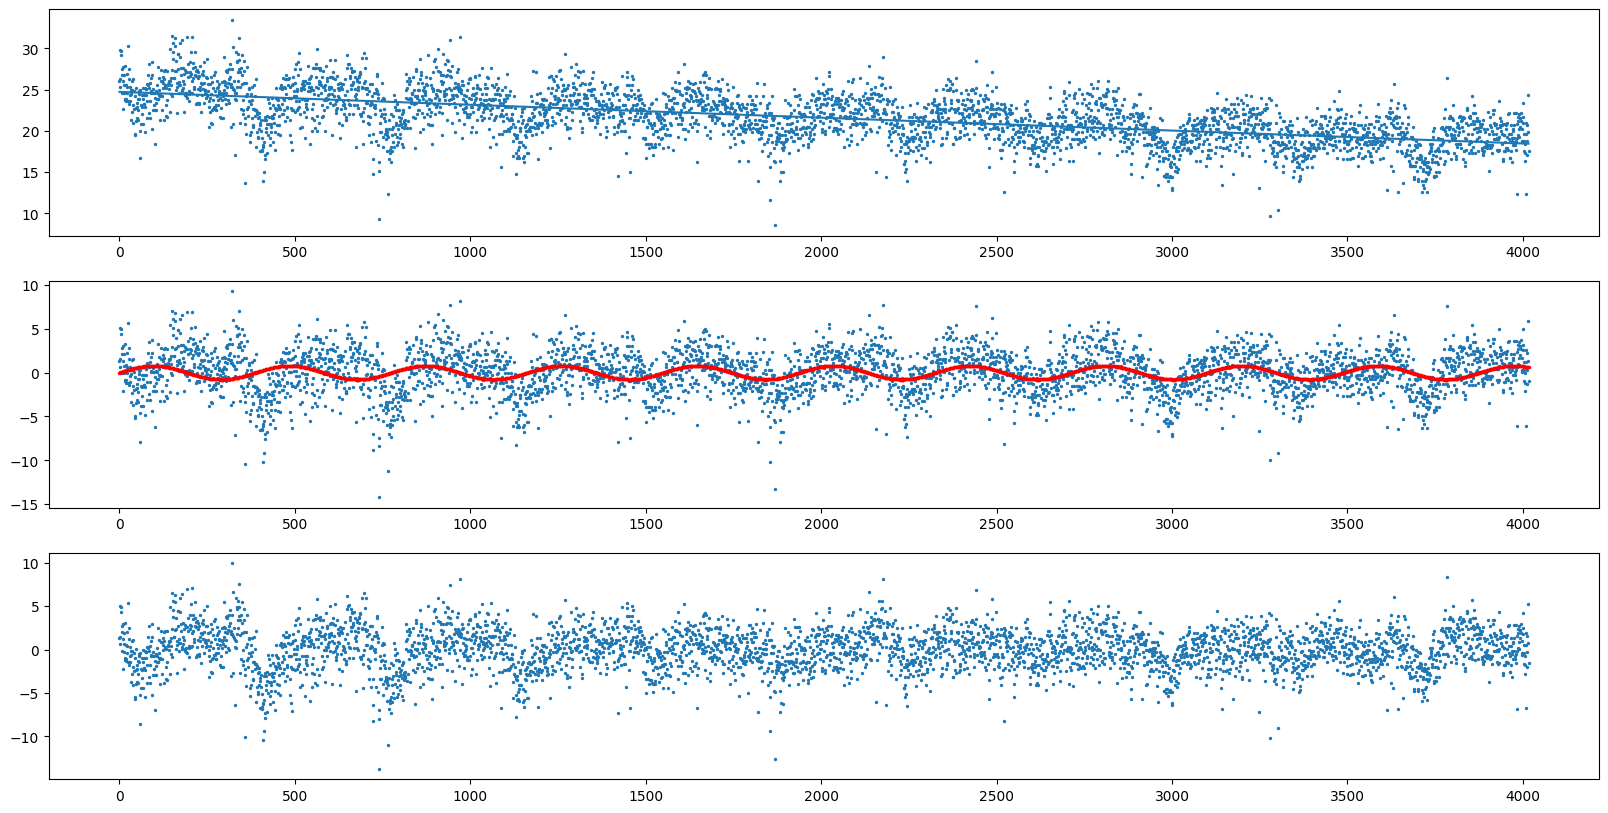

In [108]:
n = len(count_transformed)
X = np.arange(0, n, 1)
b_0, b_1 = prosta_regresji(X, count_transformed)
prosta = b_0 + b_1*X
count_bez_trendu = count_transformed - prosta

Q = np.quantile(count_bez_trendu, 0.85)
p0 = [Q, 2 * np.pi / 400, 0]
params, pcov = scipy.optimize.curve_fit(f = fun, xdata = X, ydata = count_bez_trendu, p0 = p0, bounds = ((0, 2 * np.pi / 500, 0), (30, 2 * np.pi / 300, 2 * np.pi)))
sezonowosc = np.array([fun(x, params[0], params[1], params[2]) for x in X])
count_bez_sezonu = count_bez_trendu-sezonowosc

print("Okres:",2*np.pi/params[1])
plt.figure(figsize = (20, 10))
plt.subplot(3, 1, 1)
plt.plot(X, prosta)
plt.scatter(X, count_transformed, s = 2)
plt.subplot(3, 1, 2)
plt.scatter(X, count_bez_trendu, s = 2)
plt.scatter(X, sezonowosc, c = 'r', s = 2)
plt.subplot(3, 1, 3)

plt.scatter(X, count_bez_sezonu, s = 2)

plt.show()


Test ADF - dane po dekompozycji

In [109]:
result = adfuller(count_bez_sezonu)
print("Hipoteza zerowa: dane są niestacjonarne")
print("Hipoteza alternatywna: dane są stacjonwarne")


print("ADF Statistic:", result[0])
print("p-value:", result[1])
print("Liczba opóźnień:", result[2])
print("Liczba obserwacji użytych do testu:", result[3])
print("Wartości krytyczne:")
for key, value in result[4].items():
    print(f"   {key}: {value:.3f}")

if result[1] < 0.05:
    print("Odrzucamy hipotezę zerową (dane są stacjonarne).")
else:
    print("Nie można odrzucić hipotezy zerowej (dane są niestacjonarne).")

Hipoteza zerowa: dane są niestacjonarne
Hipoteza alternatywna: dane są stacjonwarne
ADF Statistic: -6.178314831918952
p-value: 6.547932941948447e-08
Liczba opóźnień: 29
Liczba obserwacji użytych do testu: 3987
Wartości krytyczne:
   1%: -3.432
   5%: -2.862
   10%: -2.567
Odrzucamy hipotezę zerową (dane są stacjonarne).


# ACF I PACF

In [110]:
def autocov(X, h):
    n = len(X)
    result = 0
    X_mean = np.mean(X)
    h = np.abs(h)
    for i in range(n - h):
        result += (X[i] - X_mean)*(X[i +h] - X_mean)
    
    result /= n
    return result    

def autocorr(X, h):
    return (autocov(X, h)/ autocov(X,0))  

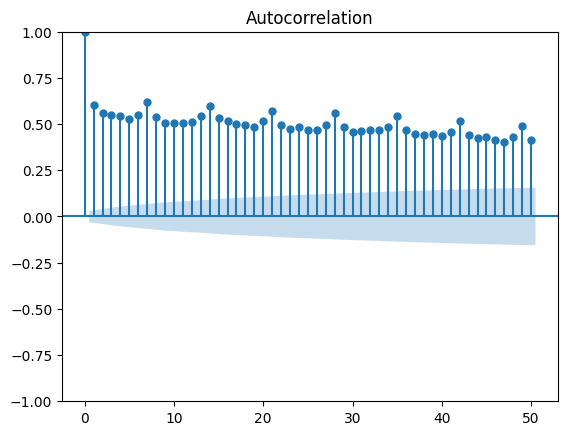

In [111]:
h = 50
plot_acf(count, lags=h, adjusted=True)
plt.show()

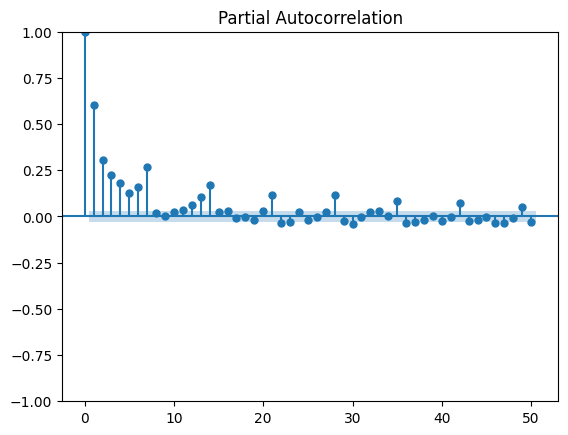

In [112]:
plot_pacf(count, lags=h, method='ywm')
plt.show()

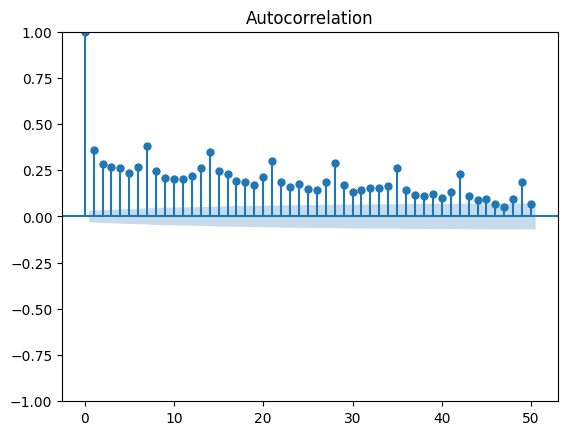

In [113]:
plot_acf(count_bez_sezonu, lags=h, adjusted=True)
plt.show()

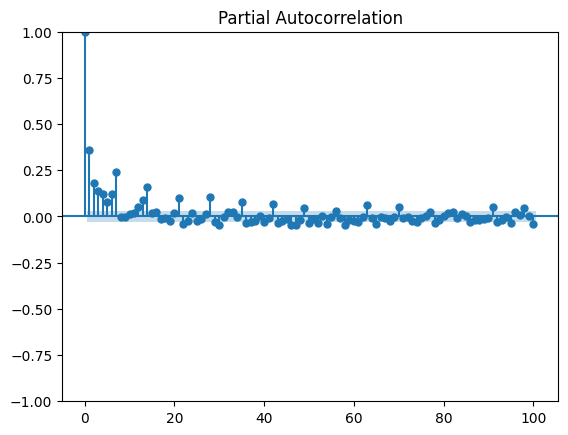

In [114]:
h = 100
plot_pacf(count_bez_sezonu, lags=h, method='ywm')
plt.show()

# MODELOWANIE DANYCH PRZY POMOCY ARMA

In [115]:
df = pd.DataFrame()
ps = []
qs = []
BIC = []
AIC = []
HQIC = []

max_p = 3
max_q = 3

for p in range(0, max_p):
    for q in range(0, max_q):
        model = ARIMA(count_bez_sezonu, order=(p, 0, q))
        model_fit = model.fit()
        ps.append(p)
        qs.append(q)
        AIC.append(model_fit.aic)
        BIC.append(model_fit.bic)
        HQIC.append(model_fit.hqic)

df['p']    = ps
df['q']    = qs
df['AIC']  = AIC
df['BIC']  = BIC
df['HQIC'] = HQIC

In [116]:
df.sort_values(by='AIC').head()

,p,q,AIC,BIC,HQIC
5,1,2,17427.279273,17458.770726,17438.439769
7,2,1,17427.371614,17458.863067,17438.532110
8,2,2,17429.217566,17467.007310,17442.610161
4,1,1,17454.706821,17479.899984,17463.635218
6,2,0,17791.555957,17816.749119,17800.484353


Bierzemy ARMA(2,2)

In [117]:
import numpy as np
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA


# Dopasowanie modelu ARMA(2,2)
model = ARIMA(count_bez_sezonu, order=(2, 0,2))  # ARMA(p=2, d=0, q=2)
fitted_model = model.fit()

# Wyświetlenie współczynników modelu
print(fitted_model.summary())

# Pobranie parametrów
ar_params = fitted_model.arparams  # Współczynniki AR
ma_params = fitted_model.maparams  # Współczynniki MA
print(f"Współczynniki AR: {ar_params}")
print(f"Współczynniki MA: {ma_params}")


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 4017
Model:                 ARIMA(2, 0, 2)   Log Likelihood               -8708.609
Date:                Fri, 24 Jan 2025   AIC                          17429.218
Time:                        17:44:39   BIC                          17467.007
Sample:                             0   HQIC                         17442.610
                               - 4017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0008      0.222      0.004      0.997      -0.435       0.437
ar.L1          1.0192      0.190      5.369      0.000       0.647       1.391
ar.L2         -0.0368      0.185     -0.198      0.8

# Przedzialy ufności PACF i ACF

In [118]:
def ARMA_22_generator(n, sigma_2, phi_1, phi_2, theta_1, theta_2):
    Z_t = np.random.normal(0, sigma_2, n+2)

    X_t = [1 , 1]
    for t in range(n):
        X = phi_1*X_t[t+1] + phi_2*X_t[t] + Z_t[t +2] +  theta_1 *Z_t[ t+1] + theta_2*Z_t[t]
        X_t.append(X)

    return X_t[2:]

In [119]:
phi_1, phi_2 = ar_params
theta_1, theta_2 = ma_params
sigma_2 = 4.4718

n = len(count_bez_sezonu)
h = 50
N = 100
X_t_vector = [ARMA_22_generator(n, sigma_2, phi_1, phi_2, theta_1, theta_2) for _ in range(N)]

ACF

In [120]:
A_empiric_acf = []
for X_t in X_t_vector:
    empiric_autocorr = [autocorr(X_t, h_value) for h_value in range(h)]

    A_empiric_acf.append(empiric_autocorr)  


In [121]:
empiric_quantile_005_values = []
empiric_quantile_095_values = []

for i in range(len(A_empiric_acf[0])):
    A_empiric_column = [A_empiric_acf[j][i] for j in range(len(X_t_vector))]

    quantile_empiric_005 = np.quantile(A_empiric_column, 0.05)
    quantile_empiric_095 = np.quantile(A_empiric_column, 0.95)
    
    empiric_quantile_005_values.append(quantile_empiric_005)
    empiric_quantile_095_values.append(quantile_empiric_095)




In [122]:
cout_acf = [autocorr(count_bez_sezonu, h_value) for h_value in range(h)]

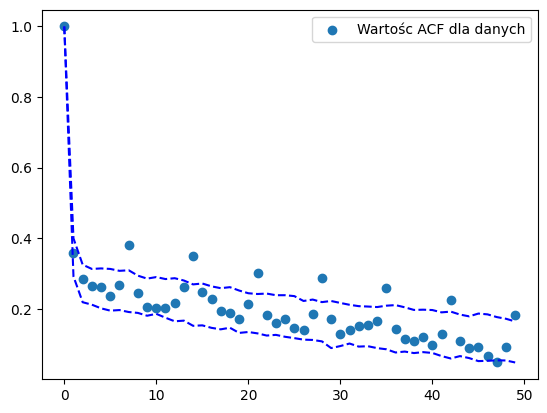

In [123]:
h_values = np.arange(0, h, 1)
plt.plot(h_values, empiric_quantile_005_values, linestyle = "--", color = "blue")
plt.plot(h_values, empiric_quantile_095_values, linestyle = "--", color = "blue")

plt.scatter(h_values, cout_acf, label= "Wartośc ACF dla danych")

plt.legend()
plt.show()


PACF

In [124]:
A_empiric_pacf = []
for X_t in X_t_vector:
    empiric_pacf = pacf(X_t, 50) 

    A_empiric_pacf.append(empiric_pacf)   

In [125]:
empiric_quantile_005_values_pacf = []
empiric_quantile_095_values_pacf = []

for i in range(len(A_empiric_pacf[0])):
    A_empiric_column = [A_empiric_pacf[j][i] for j in range(len(X_t_vector))]

    quantile_empiric_005 = np.quantile(A_empiric_column, 0.05)
    quantile_empiric_095 = np.quantile(A_empiric_column, 0.95)
    
    empiric_quantile_005_values_pacf.append(quantile_empiric_005)
    empiric_quantile_095_values_pacf.append(quantile_empiric_095)

In [126]:
count_pacf = pacf(count_bez_sezonu, 50)

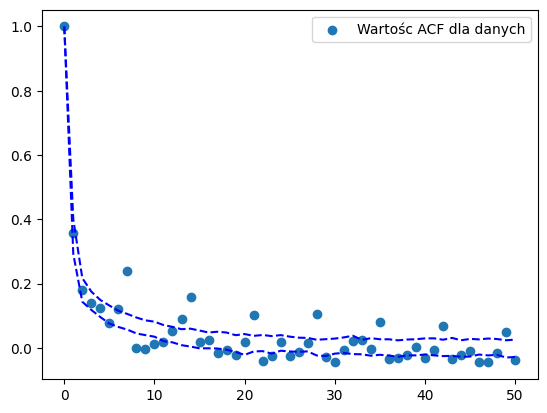

In [127]:
h_values = np.arange(0, 51, 1)
plt.plot(h_values, empiric_quantile_005_values_pacf, linestyle = "--", color = "blue")
plt.plot(h_values, empiric_quantile_095_values_pacf, linestyle = "--", color = "blue")

plt.scatter(h_values, count_pacf, label= "Wartośc ACF dla danych")

plt.legend()
plt.show()

# Linie kwantylowe z trajektorią

In [128]:
empiric_quantile_005_values_trajectory = []
empiric_quantile_095_values_trajectory = []

for i in range(len(X_t_vector[0])):
    A_empiric_column = [X_t_vector[j][i] for j in range(N)]

    quantile_empiric_005 = np.quantile(A_empiric_column, 0.05)
    quantile_empiric_095 = np.quantile(A_empiric_column, 0.95)
    
    empiric_quantile_005_values_trajectory.append(quantile_empiric_005)
    empiric_quantile_095_values_trajectory.append(quantile_empiric_095)

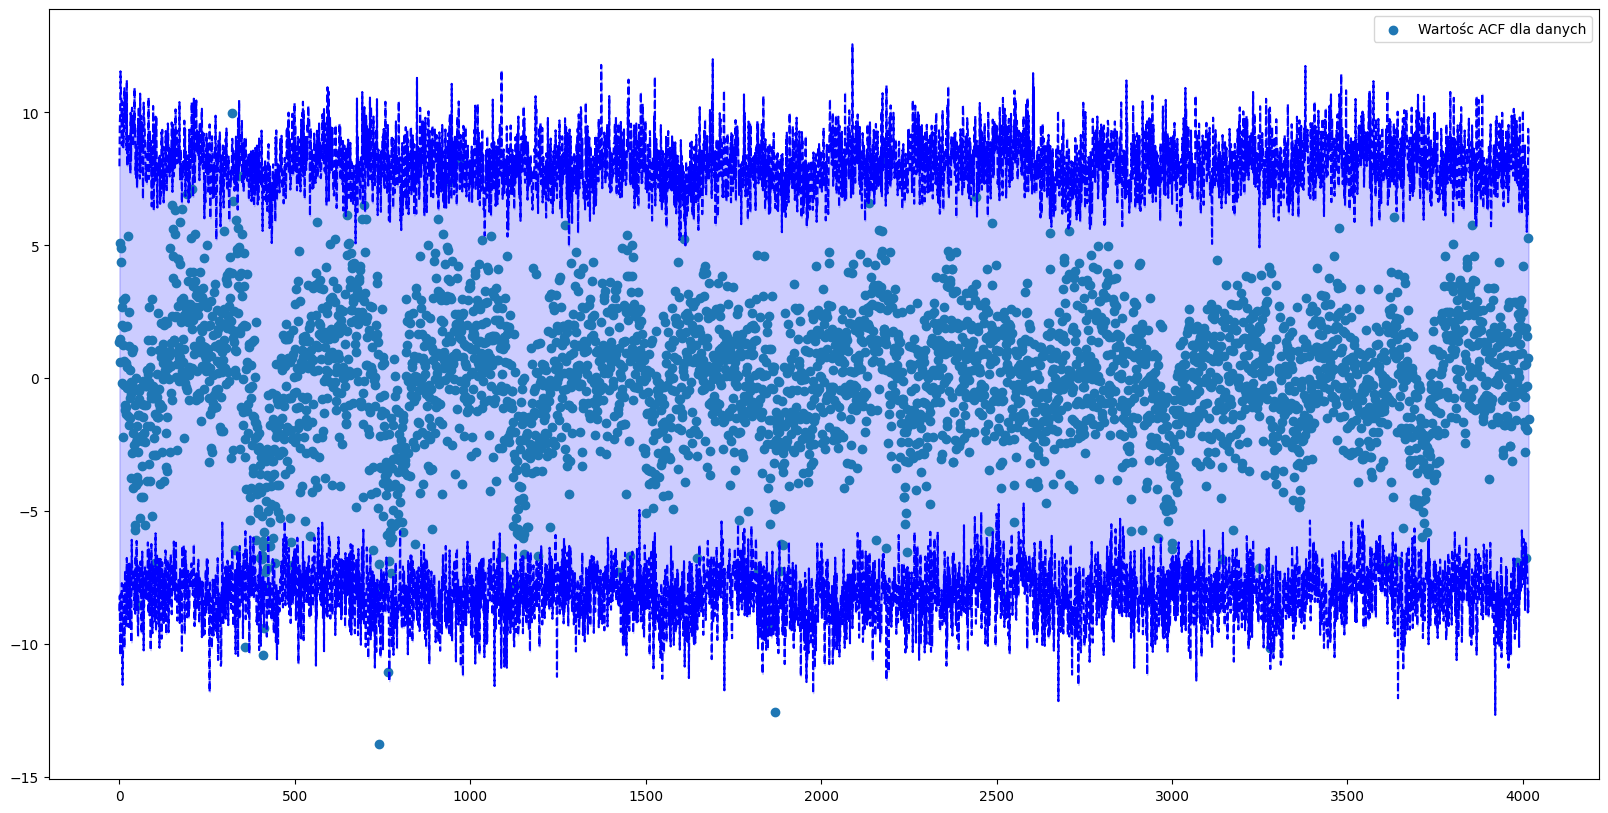

In [129]:
n_values = np.arange(0, len(count_99), 1)
plt.figure(figsize = (20, 10))
plt.plot(n_values, empiric_quantile_005_values_trajectory, linestyle = "--", color = "blue")
plt.plot(n_values, empiric_quantile_095_values_trajectory, linestyle = "--", color = "blue")

plt.fill_between(n_values, empiric_quantile_005_values_trajectory, empiric_quantile_095_values_trajectory, 
                 color="blue", alpha=0.2)

plt.scatter(n_values, count_bez_sezonu, label= "Wartośc ACF dla danych")

plt.legend()
plt.show()

# Linie kwantylowe z trajektorią (nałożony trend i sezonowość)

In [130]:
X_t_vector_z_dodatkami = X_t_vector + sezonowosc + prosta

In [131]:
empiric_quantile_005_values_trajectory_z_dodatkami = []
empiric_quantile_095_values_trajectory_z_dodatkami = []

for i in range(len(X_t_vector_z_dodatkami[0])):
    A_empiric_column = [X_t_vector_z_dodatkami[j][i] for j in range(N)]

    quantile_empiric_005 = np.quantile(A_empiric_column, 0.05)
    quantile_empiric_095 = np.quantile(A_empiric_column, 0.95)
    
    empiric_quantile_005_values_trajectory_z_dodatkami.append(quantile_empiric_005)
    empiric_quantile_095_values_trajectory_z_dodatkami.append(quantile_empiric_095)

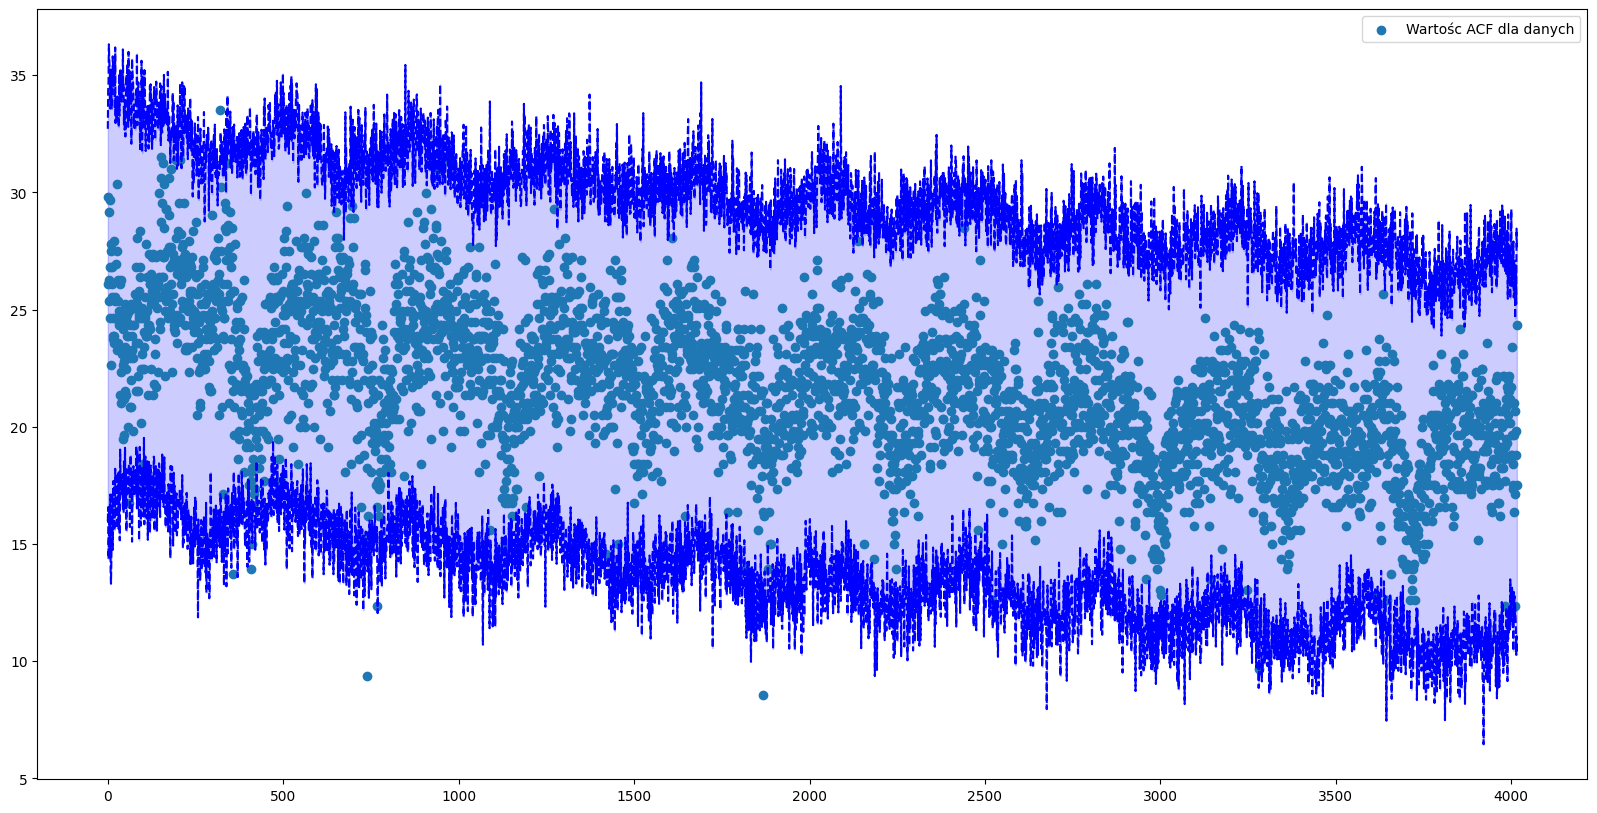

In [132]:
n_values = np.arange(0, len(count_99), 1)
plt.figure(figsize = (20, 10))
plt.plot(n_values, empiric_quantile_005_values_trajectory_z_dodatkami, linestyle = "--", color = "blue")
plt.plot(n_values, empiric_quantile_095_values_trajectory_z_dodatkami, linestyle = "--", color = "blue")

plt.fill_between(n_values, empiric_quantile_005_values_trajectory_z_dodatkami, empiric_quantile_095_values_trajectory_z_dodatkami, 
                 color="blue", alpha=0.2)

plt.scatter(n_values, count_transformed, label= "Wartośc ACF dla danych")

plt.legend()
plt.show()

# Predykcja danych

In [133]:
n = len(count)
X_t_vector = [ARMA_22_generator(n, sigma_2, phi_1, phi_2, theta_1, theta_2) for _ in range(N)]
X_t_vector_z_dodatkami = X_t_vector + sezonowosc + prosta

In [134]:
empiric_quantile_005_values_trajectory_z_dodatkami = []
empiric_quantile_095_values_trajectory_z_dodatkami = []

for i in range(len(X_t_vector_z_dodatkami[0])):
    A_empiric_column = [X_t_vector_z_dodatkami[j][i] for j in range(N)]

    quantile_empiric_005 = np.quantile(A_empiric_column, 0.05)
    quantile_empiric_095 = np.quantile(A_empiric_column, 0.95)
    
    empiric_quantile_005_values_trajectory_z_dodatkami.append(quantile_empiric_005)
    empiric_quantile_095_values_trajectory_z_dodatkami.append(quantile_empiric_095)

In [135]:
def inverse_box_cox(y_transformed, lamb):
    if lamb == 0:
        return np.exp(y_transformed)
    else:
        return (lamb * y_transformed + 1)**(1 / lamb)

quantile_005_inv_box_cox = inverse_box_cox(np.array(empiric_quantile_005_values_trajectory_z_dodatkami), lmbda_for_count)
quantile_095_inv_box_cox = inverse_box_cox(np.array(empiric_quantile_095_values_trajectory_z_dodatkami), lmbda_for_count)


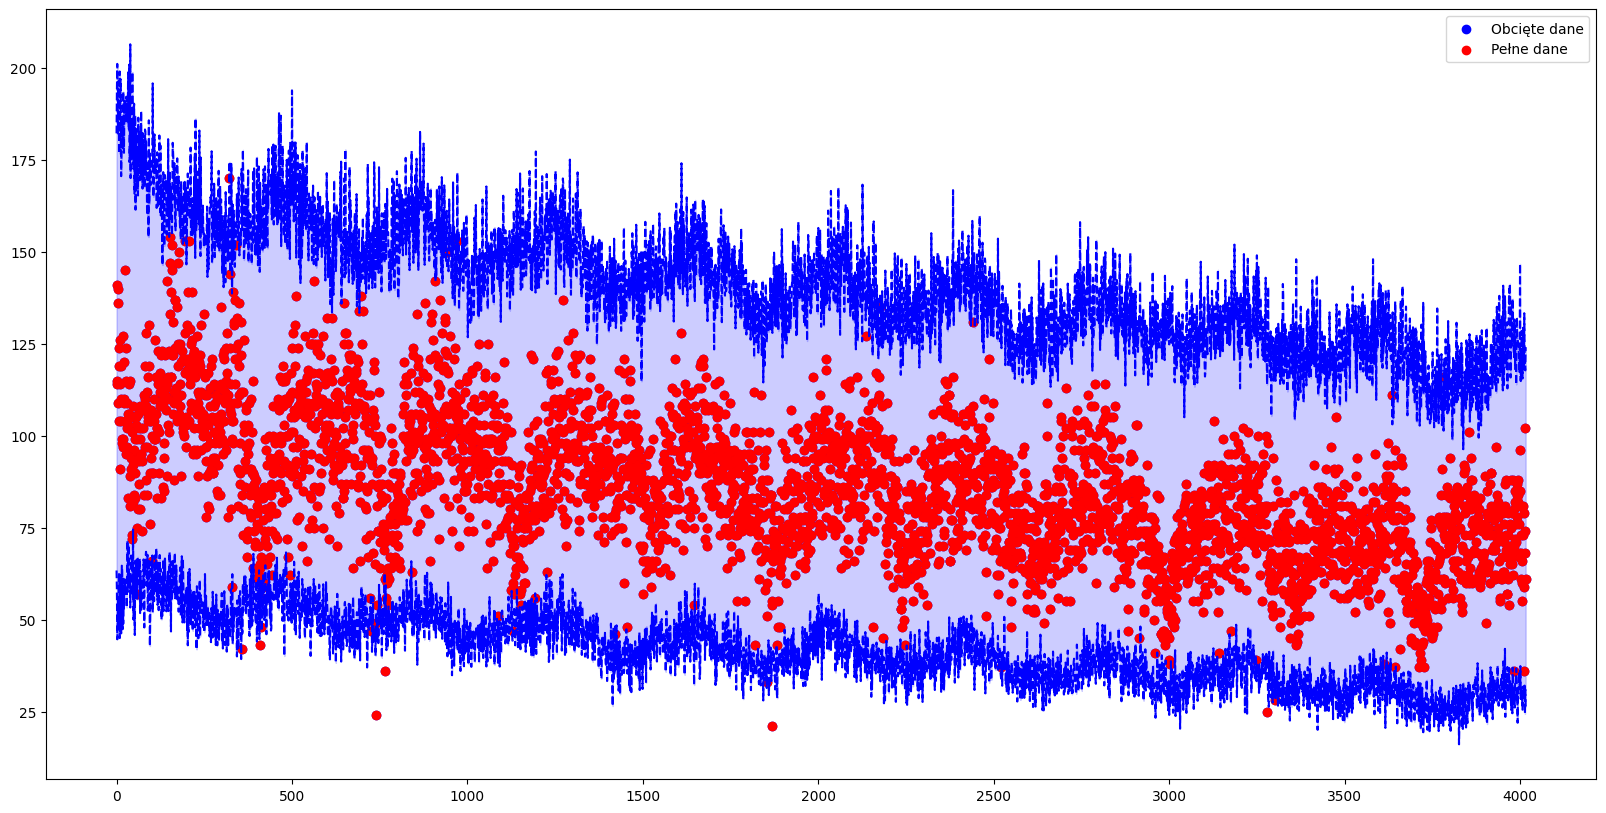

In [142]:
n_values = np.arange(0, n, 1)
plt.figure(figsize = (20, 10))
plt.plot(n_values, quantile_005_inv_box_cox, linestyle = "--", color = "blue")
plt.plot(n_values, quantile_095_inv_box_cox, linestyle = "--", color = "blue")

plt.fill_between(n_values, quantile_005_inv_box_cox, quantile_095_inv_box_cox, 
                 color="blue", alpha=0.2)

plt.scatter(n_values, count_99, color = "blue", label= "Obcięte dane")
plt.scatter(n_values, count, color = "red", label= "Pełne dane")

plt.legend()
plt.show()